# Which borough has the most noise complaints (or, more selecting data)

## Install

In [1]:
SYFT_VERSION = ">=0.8.1b0,<0.9"
package_string = f'"syft{SYFT_VERSION}"'
!pip install {package_string} -f https://whls.blob.core.windows.net/unstable/index.html -q

In [2]:
import syft as sy
sy.requires(SYFT_VERSION)

✅ The installed version of syft==0.8.1b2 matches the requirement >=0.8.1b0 and the requirement <0.9


In [3]:
node = sy.orchestra.launch(name="pandas-test-domain-1", port=8080, reset=True)

Starting pandas-test-domain-1 server on 0.0.0.0:8080
SQLite Store Path:
!open file:///var/folders/6_/7xx0tpq16h9cn40mq4w5gjk80000gn/T/6daaf5fe297b45c6a48fd24ebd1dbaf1.sqlite



# Data owner: upload data

In [4]:
domain_client = node.login(email="info@openmined.org", password="changethis")

In [5]:
# The usual preamble
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
from syft import Worker, MessageStatus
from syft.service.project.project import Project
from syft.util.util import PANDAS_DATA

# Make the graphs a bit prettier, and bigger
plt.style.use('ggplot')

# This is necessary to show lots of columns in pandas 0.12. 
# Not necessary in pandas 0.13.
pd.set_option('display.width', 5000) 
pd.set_option('display.max_columns', 60)

plt.rcParams['figure.figsize'] = (15, 5)

## Load data

We're going to use a new dataset here, to demonstrate how to deal with larger datasets. This is a subset of the of 311 service requests from NYC Open Data.

In [6]:
# because of mixed types we specify dtype to prevent any errors
complaints = pd.read_csv(sy.autocache(f"{PANDAS_DATA}/311-service-requests.csv"), dtype='unicode')

Depending on your pandas version, you might see an error like "DtypeWarning: Columns (8) have mixed types". This means that it's encountered a problem reading in our data. In this case it almost certainly means that it has columns where some of the entries are strings and some are integers.

For now we're going to ignore it and hope we don't run into a problem, but in the long run we'd need to investigate this warning.

In [7]:
complaints

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,Street Name,Cross Street 1,Cross Street 2,Intersection Street 1,Intersection Street 2,Address Type,City,Landmark,Facility Type,Status,Due Date,Resolution Action Updated Date,Community Board,Borough,X Coordinate (State Plane),Y Coordinate (State Plane),Park Facility Name,Park Borough,School Name,School Number,School Region,School Code,School Phone Number,School Address,School City,School State,School Zip,School Not Found,School or Citywide Complaint,Vehicle Type,Taxi Company Borough,Taxi Pick Up Location,Bridge Highway Name,Bridge Highway Direction,Road Ramp,Bridge Highway Segment,Garage Lot Name,Ferry Direction,Ferry Terminal Name,Latitude,Longitude,Location
0,26589651,10/31/2013 02:08:41 AM,NaN,NYPD,New York City Police Department,Noise - Street/Sidewalk,Loud Talking,Street/Sidewalk,11432,90-03 169 STREET,169 STREET,90 AVENUE,91 AVENUE,NaN,NaN,ADDRESS,JAMAICA,NaN,Precinct,Assigned,10/31/2013 10:08:41 AM,10/31/2013 02:35:17 AM,12 QUEENS,QUEENS,1042027,197389,Unspecified,QUEENS,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.70827532593202,-73.79160395779721,"(40.70827532593202, -73.79160395779721)"
1,26593698,10/31/2013 02:01:04 AM,NaN,NYPD,New York City Police Department,Illegal Parking,Commercial Overnight Parking,Street/Sidewalk,11378,58 AVENUE,58 AVENUE,58 PLACE,59 STREET,NaN,NaN,BLOCKFACE,MASPETH,NaN,Precinct,Open,10/31/2013 10:01:04 AM,NaN,05 QUEENS,QUEENS,1009349,201984,Unspecified,QUEENS,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.721040535628305,-73.90945306791765,"(40.721040535628305, -73.90945306791765)"
2,26594139,10/31/2013 02:00:24 AM,10/31/2013 02:40:32 AM,NYPD,New York City Police Department,Noise - Commercial,Loud Music/Party,Club/Bar/Restaurant,10032,4060 BROADWAY,BROADWAY,WEST 171 STREET,WEST 172 STREET,NaN,NaN,ADDRESS,NEW YORK,NaN,Precinct,Closed,10/31/2013 10:00:24 AM,10/31/2013 02:39:42 AM,12 MANHATTAN,MANHATTAN,1001088,246531,Unspecified,MANHATTAN,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.84332975466513,-73.93914371913482,"(40.84332975466513, -73.93914371913482)"
3,26595721,10/31/2013 01:56:23 AM,10/31/2013 02:21:48 AM,NYPD,New York City Police Department,Noise - Vehicle,Car/Truck Horn,Street/Sidewalk,10023,WEST 72 STREET,WEST 72 STREET,COLUMBUS AVENUE,AMSTERDAM AVENUE,NaN,NaN,BLOCKFACE,NEW YORK,NaN,Precinct,Closed,10/31/2013 09:56:23 AM,10/31/2013 02:21:10 AM,07 MANHATTAN,MANHATTAN,989730,222727,Unspecified,MANHATTAN,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.7780087446372,-73.98021349023975,"(40.7780087446372, -73.98021349023975)"
4,26590930,10/31/2013 01:53:44 AM,NaN,DOHMH,Department of Health and Mental Hygiene,Rodent,Condition Attracting Rodents,Vacant Lot,10027,WEST 124 STREET,WEST 124 STREET,LENOX AVENUE,ADAM CLAYTON POWELL JR BOULEVARD,NaN,NaN,BLOCKFACE,NEW YORK,NaN,NaN,Pending,11/30/2013 01:53:44 AM,10/31/2013 01:59:54 AM,10 MANHATTAN,MANHATTAN,998815,233545,Unspecified,MANHATTAN,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.80769092704951,-73.94738703491433,"(40.80769092704951, -73.94738703491433)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111064,26426013,10/04/2013 12:01:13 AM,10/07/2013 04:07:16 PM,DPR,Department of Parks and Recreation,Maintenance or

## Create Mock data

In [8]:
from syft.serde.mock import CachedFaker
from random import randint
import random

Let's create the mock data for the complaint dataset.

In [9]:
fake = CachedFaker()

In [10]:
fake_functions = {
    "Unique Key": lambda x: randint(1,1000000),
    "Location": lambda x: (fake.coordinate(), fake.coordinate()),
    "Agency": lambda x: random.choice(["NYPD", "DOHMH", "DPR"]),
    "X Coordinate (State Plane)": lambda x: randint(1,1000000),
    "Y Coordinate (State Plane)": lambda x: randint(1,1000000),
    "Complaint Type": lambda x: random.choice(["Illegal Parking", "Noise - Street/Sidewalk", "'Animal in a Park'"]),
    "Descriptor": lambda x: random.choice([ 'Branch or Limb Has Fallen Down','Branches Damaged','Broken Fence', 'Broken Glass']),
    "School Number": lambda x: random.choice([ 'B073', 'B077', 'B079', 'B080-01', 'B087', 'B099', 'B100', 'B102', 'B109', 'B111']),
    "Bridge Highway Segment": lambda x: random.choice([ 'Grand Central Pkwy (Exit 1 E-W)',
                                                       'Grand Central Pkwy (Exit 10) - 69th Rd-Jewel Ave (Exit 11)',
                                                       'GrandCentral Pkwy/VanWyck Expwy/College Point Blvd (Exit 22 A-E)',
                                                       'Hamilton Ave (Exit 2A) - Gowanus Expwy (I-278) (Exit 1)',
                                                       'Harding Ave (Exit 9) - Throgs Neck Br'])
}

In [11]:
fake_triggers = {
    "Street": lambda x : fake.street_name(),
    "Date": lambda x : fake.date_time(),
    "Long": lambda x : fake.coordinate(),
    "Lat": lambda x : fake.coordinate(),
    "Address": lambda x : fake.address(),
    "Name": lambda x : fake.name(),
    "City": lambda x : fake.city(),
    "Zip": lambda x : fake.zipcode(),
}

In [12]:
mock_data = dict()
for col in complaints.columns:
    col_vals = complaints[col]
    
    if col in fake_functions:
        mock_func = fake_functions[col]
    elif len(set(complaints[col])) < 100:
        values = list(set(complaints[col]))
        mock_func = lambda x: random.choice(values)
    else:
        for trigger in fake_triggers.keys():
            if trigger in col:
                mock_func = fake_triggers[trigger]
    mock_data[col] = [mock_func(None) for x in range(len(complaints))]

In [13]:
mock = pd.DataFrame(data=mock_data)

In [14]:
mock.head()

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,Street Name,Cross Street 1,Cross Street 2,Intersection Street 1,Intersection Street 2,Address Type,City,Landmark,Facility Type,Status,Due Date,Resolution Action Updated Date,Community Board,Borough,X Coordinate (State Plane),Y Coordinate (State Plane),Park Facility Name,Park Borough,School Name,School Number,School Region,School Code,School Phone Number,School Address,School City,School State,School Zip,School Not Found,School or Citywide Complaint,Vehicle Type,Taxi Company Borough,Taxi Pick Up Location,Bridge Highway Name,Bridge Highway Direction,Road Ramp,Bridge Highway Segment,Garage Lot Name,Ferry Direction,Ferry Terminal Name,Latitude,Longitude,Location
0,168467,2005-03-08 22:13:22,2003-06-26 22:01:40,DOHMH,Roberto Green,Noise - Street/Sidewalk,Branches Damaged,Day Care/Nursery,12636,5508 Wilkerson Turnpike Suite 197\nLake Edward...,Joseph Haas,Porter Lodge,Martin Pine,Gilbert Common,Steven Circles,LATLONG,West Josephfort,CITI FIELD,NaN,Unassigned,1970-02-01 04:43:41,2005-03-11 00:53:24,06 QUEENS,STATEN ISLAND,331503,539531,Allen Roberts,Unspecified,Allen Roberts,B079,Region 8,05M046,2127720210,USNV Peterson\nFPO AP 97489,SPRINGFIELD GARDENS,Unspecified,50686,NaN,NaN,Car Service,BRONX,JFK Airport,Queens Midtown Tunnel,South/East (To Throgs Neck Br),Roadway,Hamilton Ave (Exit 2A) - Gowanus Expwy (I-278)...,Grant Ave Field,Staten Island Bound,LEGAL SERVICES,78.228012,-77.090242,"(122.049171, 145.772756)"
1,285502,2011-12-31 21:01:40,1975-07-22 08:08:50,DOHMH,Eric Smith,'Animal in a Park',Branch or Limb Has Fallen Down,Commercial Building,05059,"521 Amanda Loop Suite 454\nNew Riley, AS 67871",Rebecca Mason,Lisa Highway,Howard Plains,Richard Pass,Barry Heights,INTERSECTION,North Ernestside,BARCLAYS CENTER,NaN,Unassigned,2011-03-10 06:36:56,2019-07-09 07:59:06,12 MANHATTAN,BROOKLYN,250706,380376,Jared Ayala,STATEN ISLAND,Kimberly Lambert,B077,Region 9,27Q400,2125750693,"9200 Townsend Plaza Apt. 522\nEast Raventon, N...",Unspecified,NY,85453,Y,NaN,Car Service,STATEN ISLAND,New York-Penn Station,Triborough Br,Westbound/To BQE,Ramp,Hamilton Ave (Exit 2A) - Gowanus Expwy (I-278)...,Broome and Ludlow Field,Staten Island Bound,Austen,101.851244,-19.378286,"(165.240218, -84.923668)"
2,413288,2016-07-31 12:52:59,2001-10-07 02:07:03,DPR,Shawn Sherman,Illegal Parking,Branches Damaged,Restaurant,43203,"01696 Thomas Port Suite 280\nJamesview, FL 50025",Jared Ayala,John Shore,Richard Pass,Jacqueline Island,Cindy Land,LATLONG,New Nicholas,GRAND ARMY PLAZA,NaN,Started,1974-03-28 11:24:12,1997-09-07 18:33:58,01 BROOKLYN,BROOKLYN,355360,504837,Lori Weaver,MANHATTAN,Craig Lucas,B079,Region 4,02M047,7184301800,"41957 Garcia Haven\nGrayborough, ME 97566",GLEN OAKS,Unspecified,58277,N,NaN,Commuter Van,BRONX,NaN,Throgs Neck Expwy,East/Bronx Bound,Ramp,Harding Ave (Exit 9) - Throgs Neck Br,SI Ferry Terminal,Manhattan Bound,EDITH S. RING,170.566107,-119.931580,"(-9.573158, -157.306444)"
3,269381,1994-12-10 14:27:26,1972-05-30 04:05:11,DPR,Audrey Harris,'Animal in a Park',Branches Damaged,Comercial,11419,"63400 Natasha Run Suite 666\nNorth Robin, PA 2...",Kenneth Vaughan,Cindy Forks,Charles Mews,Charles Mews,Perry Pass,ADDRESS,Jasonshire,UNION SQUARE PARK,Precinct,Email Sent,1975-07-22 08:08:50,2009-10-28 14:21:13,07 QUEENS,STATEN ISLAND,667420,283379,Roberto Green,MANHATTAN,Craig Lucas,B080-01,Region 9,27Q400,7187388100,"64901 Reed Glen\nPort Scottfurt, NC 66955",GLEN OAKS,Unspecified,21460,N,NaN,NaN,BROOKLYN,Port Authority Bus Terminal,FDR Dr,South/JFK Airport Bound,Ramp,GrandCentral Pkwy/VanWyck Expwy/College Point ...,Flatbush/Caton Field,Manhattan Bound,COUNCIL FOR SENIOR CITIZENS - SENIOR CENTER,52.373276,-12.771651,"(91.416321, 139.141103)"
4,90325,1970-02-01 04:43:41,1987-05-04 13:35:30,DPR,Tyler Kelly,Noise - Street/Sidewalk,Branches Damaged,Street/Curbside,83863,"06249 Joseph Stream\nLake Eric, NH 48001",Jessica Graha

In [15]:
dataset = sy.Dataset(name="bikes",
                     asset_list=[sy.Asset(name="complaints", data=complaints, mock=mock, mock_is_real=False)])
domain_client.upload_dataset(dataset)

  0%| | 0/1 [00:00<?,

Uploading: complaints


100%|█| 1/1 [00:03<00


<class 'syft.service.response.SyftSuccess'>: Dataset Added

## Create data scientist

In [16]:
user = domain_client.register(name="Jane Doe", email="jane@caltech.edu",
                            password="abc123", institution="Caltech", website="https://www.caltech.edu/")

# todo: give user data scientist role

guest_domain_client = node.client

guest_client = guest_domain_client.login(email="jane@caltech.edu", password="abc123")

# Data scientist: Create syft_function

## Download mock and submit project

### Get mock

In [17]:
guest_domain_client = node.client
guest_client = guest_domain_client.login(email="jane@caltech.edu", password="abc123")

In [18]:
ds = guest_domain_client.datasets[0]

In [19]:
asset = ds.assets["complaints"]

In [20]:
complaints = asset.mock.syft_action_data

### Selecting only noise complaints


I'd like to know which borough has the most noise complaints. First, we'll take a look at the data to see what it looks like:

In [21]:
complaints[:5]

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,Street Name,Cross Street 1,Cross Street 2,Intersection Street 1,Intersection Street 2,Address Type,City,Landmark,Facility Type,Status,Due Date,Resolution Action Updated Date,Community Board,Borough,X Coordinate (State Plane),Y Coordinate (State Plane),Park Facility Name,Park Borough,School Name,School Number,School Region,School Code,School Phone Number,School Address,School City,School State,School Zip,School Not Found,School or Citywide Complaint,Vehicle Type,Taxi Company Borough,Taxi Pick Up Location,Bridge Highway Name,Bridge Highway Direction,Road Ramp,Bridge Highway Segment,Garage Lot Name,Ferry Direction,Ferry Terminal Name,Latitude,Longitude,Location
0,168467,2005-03-08 22:13:22,2003-06-26 22:01:40,DOHMH,Roberto Green,Noise - Street/Sidewalk,Branches Damaged,Day Care/Nursery,12636,5508 Wilkerson Turnpike Suite 197\nLake Edward...,Joseph Haas,Porter Lodge,Martin Pine,Gilbert Common,Steven Circles,LATLONG,West Josephfort,CITI FIELD,None,Unassigned,1970-02-01 04:43:41,2005-03-11 00:53:24,06 QUEENS,STATEN ISLAND,331503,539531,Allen Roberts,Unspecified,Allen Roberts,B079,Region 8,05M046,2127720210,USNV Peterson\nFPO AP 97489,SPRINGFIELD GARDENS,Unspecified,50686,None,NaN,Car Service,BRONX,JFK Airport,Queens Midtown Tunnel,South/East (To Throgs Neck Br),Roadway,Hamilton Ave (Exit 2A) - Gowanus Expwy (I-278)...,Grant Ave Field,Staten Island Bound,LEGAL SERVICES,78.228012,-77.090242,"[122.049171, 145.772756]"
1,285502,2011-12-31 21:01:40,1975-07-22 08:08:50,DOHMH,Eric Smith,'Animal in a Park',Branch or Limb Has Fallen Down,Commercial Building,05059,"521 Amanda Loop Suite 454\nNew Riley, AS 67871",Rebecca Mason,Lisa Highway,Howard Plains,Richard Pass,Barry Heights,INTERSECTION,North Ernestside,BARCLAYS CENTER,None,Unassigned,2011-03-10 06:36:56,2019-07-09 07:59:06,12 MANHATTAN,BROOKLYN,250706,380376,Jared Ayala,STATEN ISLAND,Kimberly Lambert,B077,Region 9,27Q400,2125750693,"9200 Townsend Plaza Apt. 522\nEast Raventon, N...",Unspecified,NY,85453,Y,NaN,Car Service,STATEN ISLAND,New York-Penn Station,Triborough Br,Westbound/To BQE,Ramp,Hamilton Ave (Exit 2A) - Gowanus Expwy (I-278)...,Broome and Ludlow Field,Staten Island Bound,Austen,101.851244,-19.378286,"[165.240218, -84.923668]"
2,413288,2016-07-31 12:52:59,2001-10-07 02:07:03,DPR,Shawn Sherman,Illegal Parking,Branches Damaged,Restaurant,43203,"01696 Thomas Port Suite 280\nJamesview, FL 50025",Jared Ayala,John Shore,Richard Pass,Jacqueline Island,Cindy Land,LATLONG,New Nicholas,GRAND ARMY PLAZA,None,Started,1974-03-28 11:24:12,1997-09-07 18:33:58,01 BROOKLYN,BROOKLYN,355360,504837,Lori Weaver,MANHATTAN,Craig Lucas,B079,Region 4,02M047,7184301800,"41957 Garcia Haven\nGrayborough, ME 97566",GLEN OAKS,Unspecified,58277,N,NaN,Commuter Van,BRONX,None,Throgs Neck Expwy,East/Bronx Bound,Ramp,Harding Ave (Exit 9) - Throgs Neck Br,SI Ferry Terminal,Manhattan Bound,EDITH S. RING,170.566107,-119.931580,"[-9.573158, -157.306444]"
3,269381,1994-12-10 14:27:26,1972-05-30 04:05:11,DPR,Audrey Harris,'Animal in a Park',Branches Damaged,Comercial,11419,"63400 Natasha Run Suite 666\nNorth Robin, PA 2...",Kenneth Vaughan,Cindy Forks,Charles Mews,Charles Mews,Perry Pass,ADDRESS,Jasonshire,UNION SQUARE PARK,Precinct,Email Sent,1975-07-22 08:08:50,2009-10-28 14:21:13,07 QUEENS,STATEN ISLAND,667420,283379,Roberto Green,MANHATTAN,Craig Lucas,B080-01,Region 9,27Q400,7187388100,"64901 Reed Glen\nPort Scottfurt, NC 66955",GLEN OAKS,Unspecified,21460,N,NaN,None,BROOKLYN,Port Authority Bus Terminal,FDR Dr,South/JFK Airport Bound,Ramp,GrandCentral Pkwy/VanWyck Expwy/College Point ...,Flatbush/Caton Field,Manhattan Bound,COUNCIL FOR SENIOR CITIZENS - SENIOR CENTER,52.373276,-12.771651,"[91.416321, 139.141103]"
4,90325,1970-02-01 04:43:41,1987-05-04 13:35:30,DPR,Tyler Kelly,Noise - Street/Sidewalk,Branches Damaged,Street/Curbside,83863,"06249 Joseph Stream\nLake Eric, NH 48001",Jessica

To get the noise complaints, we need to find the rows where the "Complaint Type" column is "Noise - Street/Sidewalk". I'll show you how to do that, and then explain what's going on.



In [22]:
noise_complaints = complaints[complaints['Complaint Type'] == "Noise - Street/Sidewalk"]
noise_complaints[:3]

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,Street Name,Cross Street 1,Cross Street 2,Intersection Street 1,Intersection Street 2,Address Type,City,Landmark,Facility Type,Status,Due Date,Resolution Action Updated Date,Community Board,Borough,X Coordinate (State Plane),Y Coordinate (State Plane),Park Facility Name,Park Borough,School Name,School Number,School Region,School Code,School Phone Number,School Address,School City,School State,School Zip,School Not Found,School or Citywide Complaint,Vehicle Type,Taxi Company Borough,Taxi Pick Up Location,Bridge Highway Name,Bridge Highway Direction,Road Ramp,Bridge Highway Segment,Garage Lot Name,Ferry Direction,Ferry Terminal Name,Latitude,Longitude,Location
0,168467,2005-03-08 22:13:22,2003-06-26 22:01:40,DOHMH,Roberto Green,Noise - Street/Sidewalk,Branches Damaged,Day Care/Nursery,12636,5508 Wilkerson Turnpike Suite 197\nLake Edward...,Joseph Haas,Porter Lodge,Martin Pine,Gilbert Common,Steven Circles,LATLONG,West Josephfort,CITI FIELD,None,Unassigned,1970-02-01 04:43:41,2005-03-11 00:53:24,06 QUEENS,STATEN ISLAND,331503,539531,Allen Roberts,Unspecified,Allen Roberts,B079,Region 8,05M046,2127720210,USNV Peterson\nFPO AP 97489,SPRINGFIELD GARDENS,Unspecified,50686,None,NaN,Car Service,BRONX,JFK Airport,Queens Midtown Tunnel,South/East (To Throgs Neck Br),Roadway,Hamilton Ave (Exit 2A) - Gowanus Expwy (I-278)...,Grant Ave Field,Staten Island Bound,LEGAL SERVICES,78.228012,-77.090242,"[122.049171, 145.772756]"
4,90325,1970-02-01 04:43:41,1987-05-04 13:35:30,DPR,Tyler Kelly,Noise - Street/Sidewalk,Branches Damaged,Street/Curbside,83863,"06249 Joseph Stream\nLake Eric, NH 48001",Jessica Graham,Michelle Freeway,Taylor Ranch,Jacob Trail,Edwards Square,LATLONG,West Jeffreyborough,CITI FIELD,Precinct,Assigned,1994-01-31 02:30:18,1976-01-02 02:01:23,07 BRONX,BRONX,101444,292215,Brian Kennedy,BROOKLYN,Rebecca Wright,B111,Region 6,06M223,6463958083,"98577 Brewer Valleys\nLake Heather, MO 11609",COLLEGE POINT,Unspecified,43203,None,NaN,Car Service,BROOKLYN,JFK Airport,None,West/Brooklyn Bound,None,Grand Central Pkwy (Exit 1 E-W),SI Ferry Terminal,Staten Island Bound,STEIN SENIOR CENTER,73.482965,12.712258,"[-117.561523, -7.262388]"
15,131377,2018-10-17 14:03:03,2004-10-07 04:18:22,DOHMH,Kevin Gutierrez,Noise - Street/Sidewalk,Broken Fence,Restaurant,45485,"39960 Kristen Land\nLewisport, ND 33210",Bryan Gibson,Ramirez Islands,Joyce Green,Eaton Ways,Matthew Keys,INTERSECTION,North Brendafort,BARCLAYS CENTER,Precinct,Open,1992-03-31 04:03:32,2009-10-28 14:21:13,02 STATEN ISLAND,BRONX,778265,954368,Jerry Shah,BROOKLYN,Craig Lucas,B109,Region 5,28Q072,7189722135,"610 Michael Club Apt. 004\nMelissaton, NH 02270",HOWARD BEACH,NY,11419,Y,NaN,Ambulette / Paratransit,MANHATTAN,None,Kosciuszko Br - BQE,North/Bronx Bound,Roadway,GrandCentral Pkwy/VanWyck Expwy/College Point ...,Broome and Ludlow Field,Staten Island Bound,BRIGID OCONNOR,86.421872,-171.208504,"[52.373276, 10.266354]"


If you look at noise_complaints, you'll see that this worked, and it only contains complaints with the right complaint type. But how does this work? Let's deconstruct it into two pieces

In [23]:
complaints['Complaint Type'] == "Noise - Street/Sidewalk"

0          True
1         False
2         False
3         False
4          True
          ...  
111064    False
111065    False
111066     True
111067    False
111068    False
Name: Complaint Type, Length: 111069, dtype: bool

This is a big array of Trues and Falses, one for each row in our dataframe. When we index our dataframe with this array, we get just the rows where our boolean array evaluated to True. It's important to note that for row filtering by a boolean array the length of our dataframe's index must be the same length as the boolean array used for filtering.

You can also combine more than one condition with the & operator like this:

In [24]:
is_noise = (complaints['Complaint Type'] == "Noise - Street/Sidewalk")
in_brooklyn = complaints['Borough'] == "BROOKLYN"
complaints[is_noise & in_brooklyn][:5]

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,Street Name,Cross Street 1,Cross Street 2,Intersection Street 1,Intersection Street 2,Address Type,City,Landmark,Facility Type,Status,Due Date,Resolution Action Updated Date,Community Board,Borough,X Coordinate (State Plane),Y Coordinate (State Plane),Park Facility Name,Park Borough,School Name,School Number,School Region,School Code,School Phone Number,School Address,School City,School State,School Zip,School Not Found,School or Citywide Complaint,Vehicle Type,Taxi Company Borough,Taxi Pick Up Location,Bridge Highway Name,Bridge Highway Direction,Road Ramp,Bridge Highway Segment,Garage Lot Name,Ferry Direction,Ferry Terminal Name,Latitude,Longitude,Location
18,781546,1976-01-02 02:01:23,2019-07-09 07:59:06,NYPD,Kimberly Mitchell,Noise - Street/Sidewalk,Broken Glass,Service Provider,61934,"PSC 7450, Box 2472\nAPO AE 88056",Audrey Harris,Michael Forks,Charles Mews,Michelle Canyon,Lisa Highway,LATLONG,South James,JFK,Precinct,Unassigned,1988-10-03 13:56:44,2017-05-20 18:45:41,06 BRONX,BROOKLYN,401807,121509,Jennifer Welch,BRONX,Sean Parker,B073,Region 7,02M298,7184301800,"8315 Everett Isle Suite 640\nNew Barbara, PA 5...",ELMHURST,NY,33124,Y,NaN,Ambulette / Paratransit,BROOKLYN,New York-Penn Station,Cross Island Pkwy,North Bound,Roadway,Hamilton Ave (Exit 2A) - Gowanus Expwy (I-278)...,Flushing #3 Field,Manhattan Bound,LEGAL SERVICES,-70.978369,-19.378286,"[-166.905799, 33.795102]"
99,661974,2015-12-20 11:32:50,2009-02-08 19:53:55,DOHMH,Benjamin Myers,Noise - Street/Sidewalk,Broken Glass,Street Address,54216,"88671 Jimmy Hills\nWandabury, VT 17110",Kimberly Mitchell,Samantha Fort,Pamela Viaduct,Martin Hills,Hall Islands,INTERSECTION,Anthonyfurt,BARCLAYS CENTER,None,Unassigned,1991-12-18 01:49:37,2016-07-31 12:52:59,11 BRONX,BROOKLYN,165875,990946,Craig Lucas,QUEENS,Brian Hernandez,B087,Region 3,10X046,7184025160,"940 Stacy Brook\nEast Christopher, KS 62182",OZONE PARK,NY,78931,Y,NaN,Commuter Van,BROOKLYN,Grand Central Station,Clearview Expwy,Southbound,Roadway,Harding Ave (Exit 9) - Throgs Neck Br,Flushing #3 Field,Manhattan Bound,FRANCISCA URBANO,-19.598742,165.240218,"[-60.018397, 15.482819]"
147,253701,2021-01-23 17:40:36,2016-05-26 00:33:46,NYPD,Aaron Collins,Noise - Street/Sidewalk,Broken Glass,Crosswalk,43582,"848 Garcia Ridge Apt. 900\nEast Kimberlyfurt, ...",Lisa Elliott,Kelly Glen,Martin Mission,Brown Avenue,Johnson Springs,LATLONG,East William,BETH ISRAEL MED CENTER,School,Open,1976-11-19 14:28:30,1980-12-20 11:01:41,27 BRONX,BROOKLYN,87279,897050,Elizabeth Wheeler,Unspecified,Tracy Valdez,B087,Region 8,15K015,7188605544,"870 Kelly Key\nBakerfort, HI 39585",STATEN ISLAND,Unspecified,67252,N,NaN,Car Service,STATEN ISLAND,JFK Airport,Prospect Expwy,East/Long Island Bound,None,Harding Ave (Exit 9) - Throgs Neck Br,Steinway #1 and #2 Field,Manhattan Bound,JACK PARKER,-19.226765,-154.723017,"[-26.125122, 130.699906]"
197,703892,2018-08-07 05:15:04,1988-10-03 13:56:44,NYPD,Natalie Tapia,Noise - Street/Sidewalk,Branch or Limb Has Fallen Down,Street Fair Vendor,19656,"98577 Brewer Valleys\nLake Heather, MO 11609",Michael White,Jamie Summit,Scott Plains,Chelsea Key,Brandon Orchard,INTERSECTION,Jeremytown,VAN CORTLANDT PARK,DSNY Garage,Started,1989-01-30 15:26:54,1987-05-04 13:35:30,03 BROOKLYN,BROOKLYN,121921,762978,Christopher Williams,MANHATTAN,Tracy Valdez,B087,Region 5,30Q150,7189658999,"860 Hall Villages Suite 024\nByrdbury, WA 10052",REGO PARK,Unspecified,18088,Y,NaN,Car Service,STATEN ISLAND,Grand Central Station,West Shore Expwy,South/Long Island Bound,None,GrandCentral Pkwy/VanWyck Expwy/College Point ...,Flushing #1 Field,Staten Island Bound,FLOR VALENTIN,-116.690737,139.141103,"[38.656670, -53.311446]"
199,108051,1991-12-18 01:49:37,1988-08-21 22:18:43,DPR,Audrey Harris,Noise - Street/Sidewalk,Broken Glass,Crosswalk,05613,0147 Sharon Harbors Suite 267\nNorth Raymondfu...,Brett Ryan,Barry Heigh

Or if we just wanted a few columns:



In [25]:
complaints[is_noise & in_brooklyn][['Complaint Type', 'Borough', 'Created Date', 'Descriptor']][:10]

,Complaint Type,Borough,Created Date,Descriptor
18,Noise - Street/Sidewalk,BROOKLYN,1976-01-02 02:01:23,Broken Glass
99,Noise - Street/Sidewalk,BROOKLYN,2015-12-20 11:32:50,Broken Glass
147,Noise - Street/Sidewalk,BROOKLYN,2021-01-23 17:40:36,Broken Glass
197,Noise - Street/Sidewalk,BROOKLYN,2018-08-07 05:15:04,Branch or Limb Has Fallen Down
199,Noise - Street/Sidewalk,BROOKLYN,1991-12-18 01:49:37,Broken Glass
236,Noise - Street/Sidewalk,BROOKLYN,1994-01-31 02:30:18,Branch or Limb Has Fallen Down
246,Noise - Street/Sidewalk,BROOKLYN,1983-04-04 03:36:29,Broken Glass
249,Noise - Street/Sidewalk,BROOKLYN,1988-10-03 13:56:44,Branch or Limb Has Fallen Down
260,Noise - Street/Sidewalk,BROOKLYN,2001-07-03 22:05:46,Broken Fence
306,Noise - Street/Sidewalk,BROOKLYN,1987-04-16 13:28:31,Broken Glass


### A digression about numpy arrays

On the inside, the type of a column is pd.Series

In [26]:
import pandas as pd
import numpy as np

In [27]:
pd.Series([1,2,3])

0    1
1    2
2    3
dtype: int64

and pandas Series are internally numpy arrays. If you add .values to the end of any Series, you'll get its internal numpy array

In [28]:
np.array([1,2,3])

array([1, 2, 3])

In [29]:
pd.Series([1,2,3]).values

array([1, 2, 3])

So this binary-array-selection business is actually something that works with any numpy array:

In [30]:
arr = np.array([1,2,3])

In [31]:
arr != 2

array([ True, False,  True])

In [32]:
arr[arr != 2]

array([1, 3])

### So, which borough has the most noise complaints?

In [33]:
is_noise = complaints['Complaint Type'] == "Noise - Street/Sidewalk"
noise_complaints = complaints[is_noise]
noise_complaints['Borough'].value_counts()

STATEN ISLAND    6278
BROOKLYN         6204
MANHATTAN        6193
BRONX            6151
Unspecified      6140
QUEENS           6068
Name: Borough, dtype: int64

It's the BRONX (for this Mock)! But what if we wanted to divide by the total number of complaints, to make it make a bit more sense? That would be easy too:

In [34]:
noise_complaint_counts = noise_complaints['Borough'].value_counts()
complaint_counts = complaints['Borough'].value_counts()

In [35]:
noise_complaint_counts

STATEN ISLAND    6278
BROOKLYN         6204
MANHATTAN        6193
BRONX            6151
Unspecified      6140
QUEENS           6068
Name: Borough, dtype: int64

In [36]:
noise_complaint_counts / complaint_counts

BRONX            0.333767
BROOKLYN         0.334105
MANHATTAN        0.334053
QUEENS           0.329049
STATEN ISLAND    0.336983
Unspecified      0.332593
Name: Borough, dtype: float64

Oops, why was that zero? That's no good. This is because of integer division in Python 2. Let's fix it, by converting complaint_counts into an array of floats.

In [37]:
noise_complaint_counts / complaint_counts.astype(float)

BRONX            0.333767
BROOKLYN         0.334105
MANHATTAN        0.334053
QUEENS           0.329049
STATEN ISLAND    0.336983
Unspecified      0.332593
Name: Borough, dtype: float64

<Axes: >

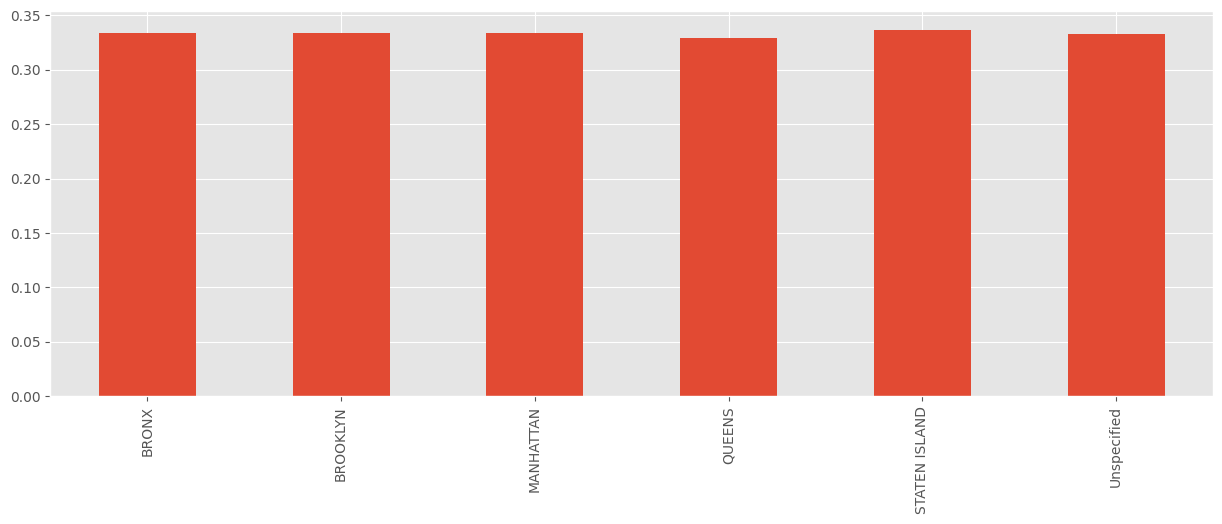

In [38]:
(noise_complaint_counts / complaint_counts.astype(float)).plot(kind='bar')

So Bronx really does complain more about noise than the other boroughs in our mock! Neat.

## Request real result

Now that we finished our analysis on the mock data, we can request this execution on the real data.

In [39]:
@sy.syft_function(input_policy=sy.ExactMatch(complaints=asset.mock),
                  output_policy=sy.SingleExecutionExactOutput())
def get_counts(complaints):
    is_noise = complaints['Complaint Type'] == "Noise - Street/Sidewalk"
    noise_complaints = complaints[is_noise]
    noise_complaint_counts = noise_complaints['Borough'].value_counts()
    complaint_counts = complaints['Borough'].value_counts()
    return noise_complaint_counts / complaint_counts.astype(float)

Request code execution

In [40]:
req = guest_domain_client.api.services.code.request_code_execution(get_counts)

In [41]:
submitted_code = guest_domain_client.code[0]

In [42]:
assert guest_domain_client.api.services.code.get_all()

Create and submit project

In [43]:
new_project = sy.Project(name="Pandas chapter 3",
                         description="Hi, I would like to plot the histogram of the noise complaint counts per area.")

In [44]:
new_project.add_request(obj=submitted_code, permission=sy.UserCodeStatus.EXECUTE)

In [45]:
guest_domain_client.submit_project(new_project)

<class 'syft.service.response.SyftSuccess'>: Project Submitted

# Data owner: execute function

## Get messages

In [46]:
domain_client = node.login(email="info@openmined.org", password="changethis")

In [47]:
messages = domain_client.api.services.messages.get_all_for_status(MessageStatus.UNDELIVERED)

In [48]:
messages

,type,id,subject,status,created_at,linked_obj
0,syft.service.message.messages.Message,808cb7f88f164a918aae5c5d1bd99628,Approval Request,MessageStatus.UNDELIVERED,2023-05-16 11:50:52,<<class 'syft.service.request.request.Request'...
1,syft.service.message.messages.Message,74d67f27e38846bda9b13bb934e9ddac,Project Approval,MessageStatus.UNDELIVERED,2023-05-16 11:50:53,<<class 'syft.service.project.project.Project'...


In [49]:
project_message = [x for x in messages if issubclass(x.linked_obj.object_type, Project)][0]

In [50]:
request = project_message.link.requests[0]
func = request.changes[0].link
op = func.output_policy_type

In [51]:
func

```python
class UserCode:
  id: str = d5b9834c48614ce19d1138927078ffca
  node_uid: str = 6daaf5fe297b45c6a48fd24ebd1dbaf1
  user_verify_key: str = 9f04f1987d2f11879f149c5efdff375474dedca06600af7ead71bf6c4dc71944
  raw_code: str = "@sy.syft_function(input_policy=sy.ExactMatch(complaints=asset.mock),
                  output_policy=sy.SingleExecutionExactOutput())
def get_counts(complaints):
    is_noise = complaints['Complaint Type'] == "Noise - Street/Sidewalk"
    noise_complaints = complaints[is_noise]
    noise_complaint_counts = noise_complaints['Borough'].value_counts()
    complaint_counts = complaints['Borough'].value_counts()
    return noise_complaint_counts / complaint_counts.astype(float)
"
  input_policy_type: str = <class 'syft.service.policy.policy.ExactMatch'>
  input_policy_init_kwargs: str = {NodeView(node_name='pandas-test-domain-1', verify_key=878b723a132be3d48f165377e5af95f6ed6e9ae0b3a506f2318c8cc6d0ebdb11): {'complaints': <UID: 4bb92aafc01c428886b3f1355e0b7a74>}}
  input_policy_state: str = b''
  output_policy_type: str = <class 'syft.service.policy.policy.OutputPolicyExecuteOnce'>
  output_policy_init_kwargs: str = {}
  output_policy_state: str = b''
  parsed_code: str = "def user_func_get_counts_9f04f1987d2f11879f149c5efdff375474dedca06600af7ead71bf6c4dc71944_701f23755a69b9f3f6d34d6a02c53686edbd4a524ddd4cb2d4815c33b33a5b20(complaints):

    def get_counts(complaints):
        is_noise = complaints['Complaint Type'] == 'Noise - Street/Sidewalk'
        noise_complaints = complaints[is_noise]
        noise_complaint_counts = noise_complaints['Borough'].value_counts()
        complaint_counts = complaints['Borough'].value_counts()
        return noise_complaint_counts / complaint_counts.astype(float)
    result = get_counts(complaints=complaints)
    return result"
  service_func_name: str = "get_counts"
  unique_func_name: str = "user_func_get_counts_9f04f1987d2f11879f149c5efdff375474dedca06600af7ead71bf6c4dc71944_701f23755a69b9f3f6d34d6a02c53686edbd4a524ddd4cb2d4815c33b33a5b20"
  user_unique_func_name: str = "user_func_get_counts_9f04f1987d2f11879f149c5efdff375474dedca06600af7ead71bf6c4dc71944"
  code_hash: str = "701f23755a69b9f3f6d34d6a02c53686edbd4a524ddd4cb2d4815c33b33a5b20"
  signature: str = (complaints)
  status: str = {NodeView(node_name='pandas-test-domain-1', verify_key=878b723a132be3d48f165377e5af95f6ed6e9ae0b3a506f2318c8cc6d0ebdb11): <UserCodeStatus.SUBMITTED: 'submitted'>}
  input_kwargs: str = ['complaints']
  enclave_metadata: str = None

```

In [52]:
get_counts_user_func = func.unsafe_function

In [53]:
real_data = domain_client.datasets[0].assets[0].data

In [54]:
real_result = get_counts_user_func(complaints=real_data)

In [55]:
real_result[:3]

BRONX        0.014833
BROOKLYN     0.013864
MANHATTAN    0.037755
Name: Borough, dtype: float64

In [56]:
result = request.accept_by_depositing_result(real_result)
result
assert isinstance(result, sy.SyftSuccess)

# Data scientist: fetch result

In [57]:
asset = guest_client.datasets[0].assets[0]

In [58]:
guest_client.api.services.code[0].status

{NodeView(node_name='pandas-test-domain-1', verify_key=878b723a132be3d48f165377e5af95f6ed6e9ae0b3a506f2318c8cc6d0ebdb11): <UserCodeStatus.EXECUTE: 'execute'>}

```python
Pointer
```
<Axes: >

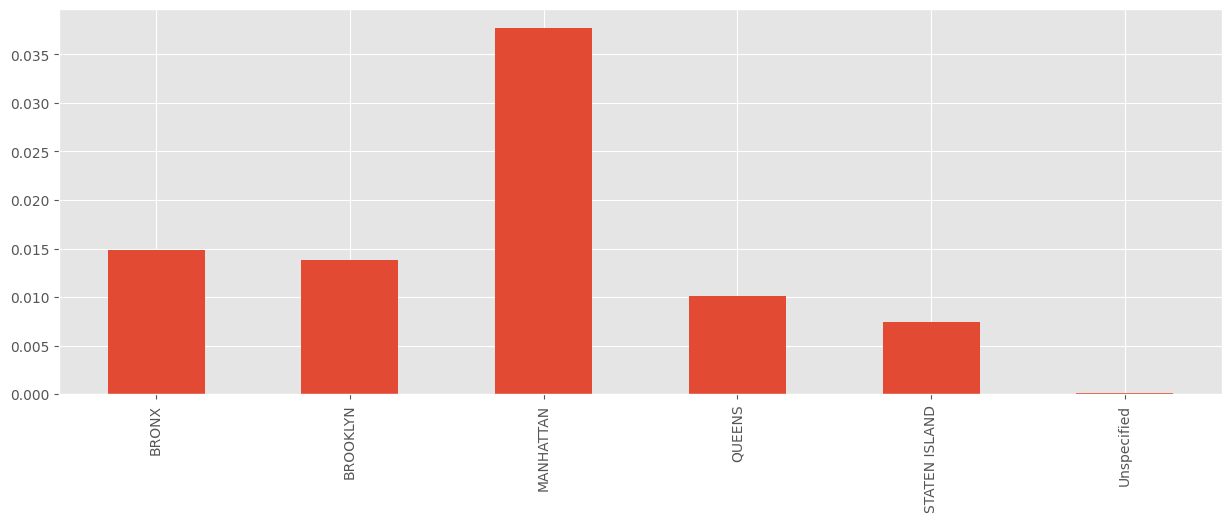

In [59]:
real_result = guest_client.api.services.code.get_counts(complaints=asset)
real_result.plot(kind="bar")

In [60]:
if node.node_type.value == "python":
    node.land()

Stopping pandas-test-domain-1
